__NAME:__ __Venkata Subbaraju Sagi__  
__mail:__ __subbaraju.v@ou.edu__  


### Project overview
For this project I will be exploring support vector machines (SVMs)
using GridsearchCV and working with highly unbalanced datasets.


### [Data set](https://www.kaggle.com/kerneler/starter-credit-card-fraud-detection-e6d0de2d-9)
European Cardholder Credit Card Transactions, September 2013  
This dataset presents transactions that occurred over two days. There were 492 incidents of 
frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class 
(frauds) accounts for 0.197% of all transactions.

__Features__  
* V1, V2, ... V28: are principal components obtained with PCA  
* Time: the seconds elapsed between each transaction and the first transaction  
* Amount: is the transaction Amount  
* Class: the predicted variable; 1 in case of fraud and 0 otherwise.  

Given the class imbalance ratio, it is recommended to use precision, recall and the 
Area Under the Precision-Recall Curve (AUPRC) to evaluate skill. Traditional accuracy 
and AUC are not meaningful for highly unbalanced classification. These scores are 
misleading due to the high impact of the large number of negative cases that can easily
be identified. 

Examining precision and recall is more informative as these disregard the number of 
correctly identified negative cases (i.e. TN) and focus on the number of correctly 
identified positive cases (TP) and mis-identified negative cases (FP). Another useful 
metric is the F1 score which is the harmonic mean of the precision and recall; 1 is the 
best F1 score.

Confusion Matrix  
[TN  FP]  
[FN  TP]

Accuracy = $\frac{TN + TP}{TN + TP + FN + FP}$  
TPR = $\frac{TP}{TP + FN}$  
FPR = $\frac{FP}{FP + TN}$  

Recall = TPR = $\frac{TP}{TP + FN}$  
Precision = $\frac{TP}{TP + FP}$  
F1 Score = 2 * $\frac{precision * recall}{precision + recall}$  

See the general resoucres below for more details on precision, recall, and the F1 score.


The dataset was collected and analysed during a research collaboration of 
Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université 
Libre de Bruxelles) on big data mining and fraud detection [1]

[1] Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi.
Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium
on Computational Intelligence and Data Mining (CIDM), IEEE, 2015.
http://mlg.ulb.ac.be/BruFence . http://mlg.ulb.ac.be/ARTML




In [0]:
import visualize
import metrics_plots
from pipeline_components import DataSampleDropper, DataFrameSelector

import pandas as pd
import numpy as np
#import seaborn
import scipy.stats as stats
import os, re, fnmatch
import pathlib, itertools
import time as timelib
import matplotlib.pyplot as plt

from math import floor, ceil
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import make_scorer, precision_recall_curve
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import roc_curve, auc, f1_score, recall_score
from sklearn.svm import SVC
from sklearn.externals import joblib

HOME_DIR = pathlib.Path.home()
CW_DIR = pathlib.Path.cwd()

FIGW = 12
FIGH = 5
FONTSIZE = 8

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline

In [0]:
HOME_DIR

PosixPath('/home/jovyan')

# LOAD DATA

In [0]:
# 284806 rows, 'None' to read whole file
nRowsRead = None 

# TODO: set to appropriate system path of data 
# Obtain data from Canvas Homework Solutions folder

dir_name = str(HOME_DIR /'hw8/')
filename = 'creditcard.csv'

crime_stats_full = pd.read_csv(filename, delimiter=',', nrows=nRowsRead)
crime_stats_full.dataframeName = 'creditcard.csv'
nRows, nCols = crime_stats_full.shape
print(f'There are {nRows} rows and {nCols} columns')

There are 284806 rows and 31 columns


In [0]:
crime_stats_full.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
"""
good (negative case = 0)
fraud (positive case = 1)
"""
targetnames = ['good', 'fraud']

pos_full = crime_stats_full.loc[crime_stats_full['Class'] == 1] 
neg_full = crime_stats_full.loc[crime_stats_full['Class'] == 0] 

pos_full.shape, neg_full.shape

((492, 31), (284314, 31))

In [0]:
""" 
Computing the postive fraction
"""
pos_fraction = pos_full.shape[0] / nRows
neg_fraction = 1 - pos_fraction

pos_fraction, neg_fraction

(0.001727491696101908, 0.9982725083038981)

In [0]:
""" 
Selecting Random Subset of data
"""
np.random.seed(42)
subset_size = 20000
selected_indices = np.random.choice(range(nRows), size=subset_size, replace=False)
selected_indices

array([ 43428,  49906,  29474, ..., 192406, 124100,  12947])

In [0]:
""" 
Listing the features and shape of the data
"""
crime_stats = crime_stats_full.loc[selected_indices, :]
crime_stats.columns, crime_stats.shape

(Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
        'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
        'Class'],
       dtype='object'), (20000, 31))

In [0]:
""" 
Displaying whether there are any NaNs
"""
crime_stats.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [0]:
""" 
Display summary statistics for each feature
You can use describe() for this
"""

crime_stats.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,94490.802400,0.002913,-0.029847,-0.001526,0.018716,-0.009522,-0.002003,-0.008675,0.004225,-0.000767,...,-0.002876,0.000937,0.002760,0.000499,0.004572,-0.003928,-0.000498,-0.001587,89.525975,0.00155
std,47313.538305,2.011012,1.721684,1.545744,1.414560,1.390694,1.325199,1.223386,1.172031,1.105181,...,0.714353,0.719430,0.616109,0.603601,0.517540,0.478031,0.437142,0.349640,247.838774,0.03934
min,0.000000,-40.042538,-48.060856,-30.177317,-5.266509,-23.611865,-20.869626,-31.197329,-37.353443,-9.462573,...,-13.963731,-8.887017,-22.575000,-2.824849,-4.196468,-2.068561,-22.565679,-11.710896,0.000000,0.00000
25%,54111.000000,-0.916870,-0.607590,-0.904430,-0.840008,-0.713130,-0.761379,-0.564197,-0.206495,-0.644663,...,-0.228380,-0.543027,-0.161554,-0.352267,-0.311738,-0.325381,-0.070359,-0.052049,5.760000,0.00000
50%,84335.500000,0.041402,0.053039,0.186126,0.003204,-0.066121,-0.270283,0.025205,0.021737,-0.048547,...,-0.030045,0.007540,-0.011669,0.044262,0.027412,-0.055531,0.001234,0.010908,22.035000,0.00000
75%,139023.250000,1.329557,0.780855,1.047085,0.758450,0.593397,0.393435,0.562905,0.325365,0.597407,...,0.181191,0.526424,0.147149,0.441184,0.351777,0.231973,0.088768,0.078558,77.720000,0.00000
max,172782.000000,2.451888,16.497472,9.382558,12.699542,26.647697,16.493227,21.437514,17.052566,15.594995,...,27.202839,4.080214,19.002942,3.546031,4.513681,2.952093,9.200883,16.129609,8787.000000,1.00000


# VISUALIZE DATA

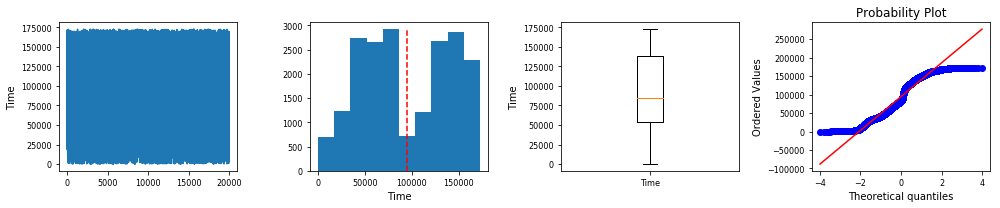

myplots Time


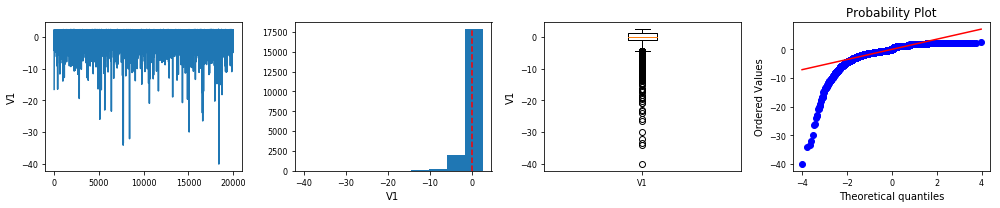

myplots V1


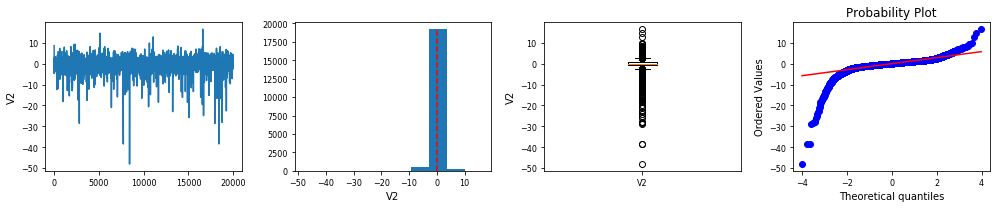

myplots V2


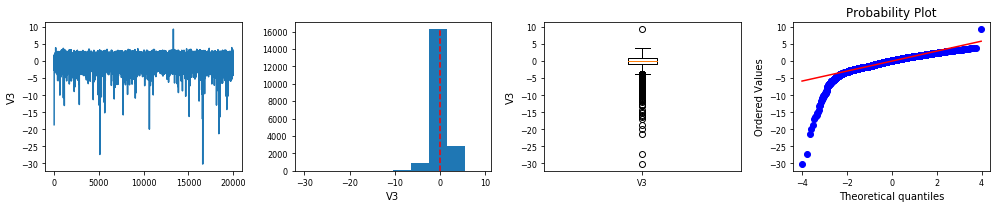

myplots V3


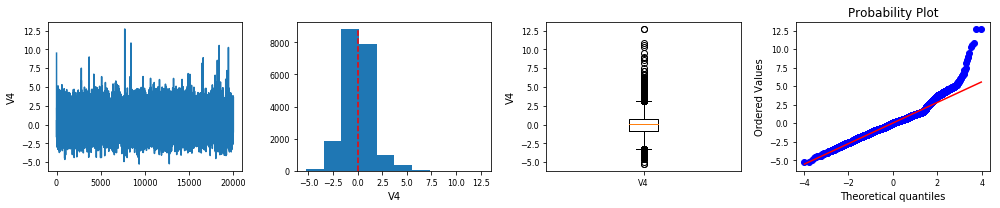

myplots V4


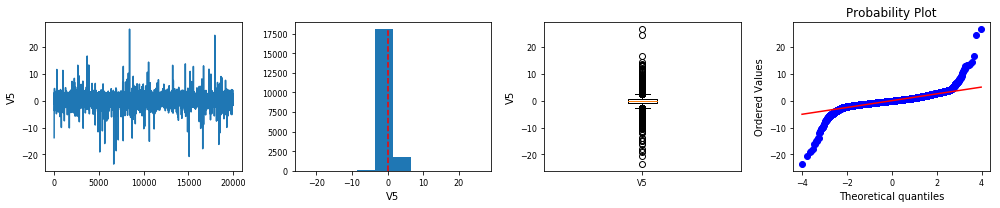

myplots V5


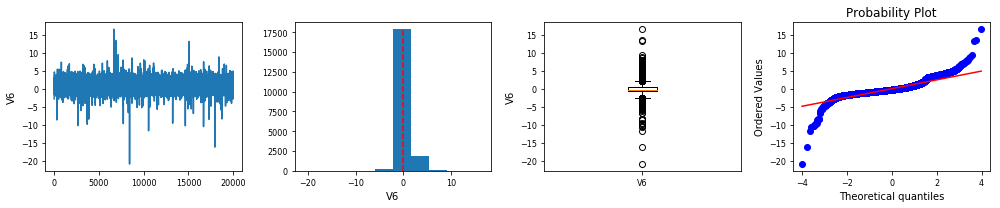

myplots V6


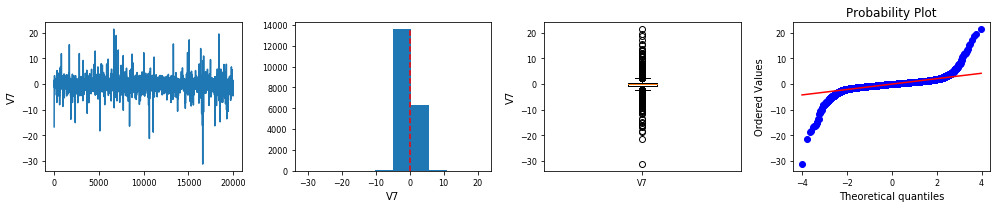

myplots V7


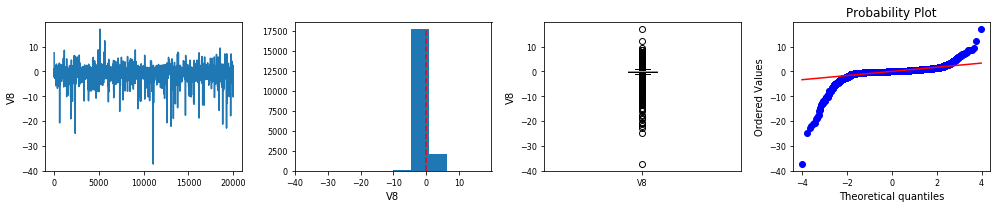

myplots V8


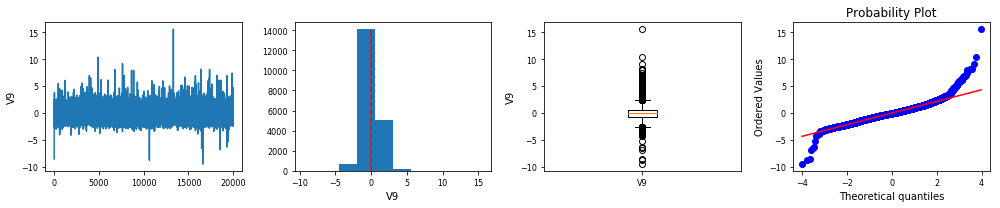

myplots V9


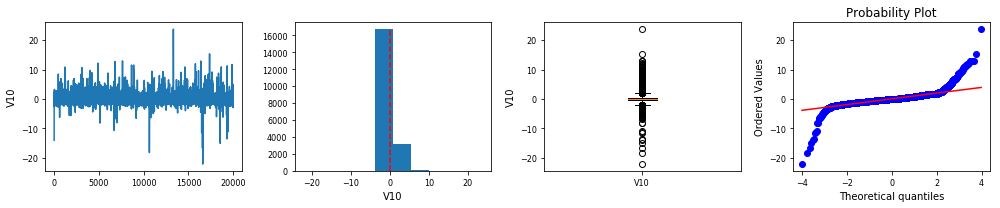

myplots V10


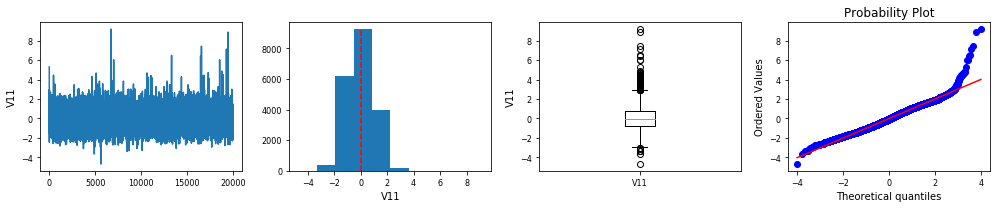

myplots V11


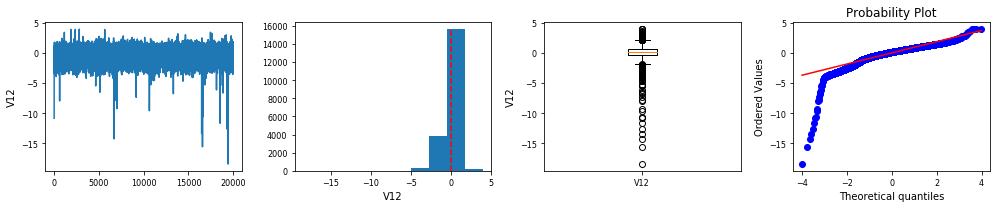

myplots V12


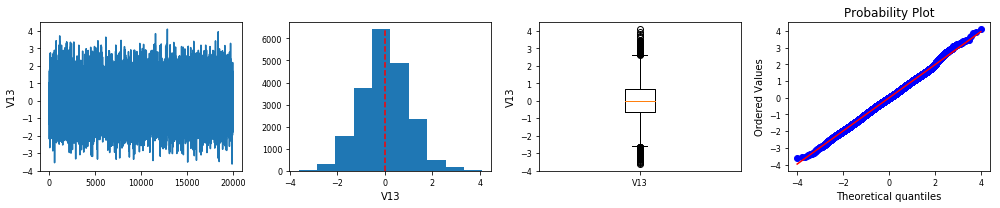

myplots V13


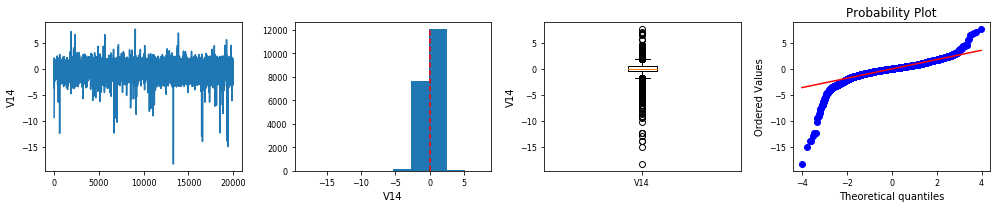

myplots V14


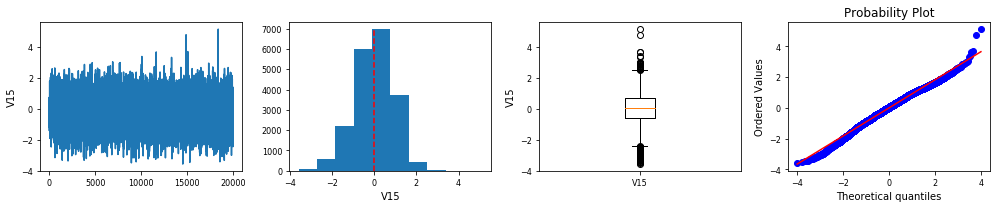

myplots V15


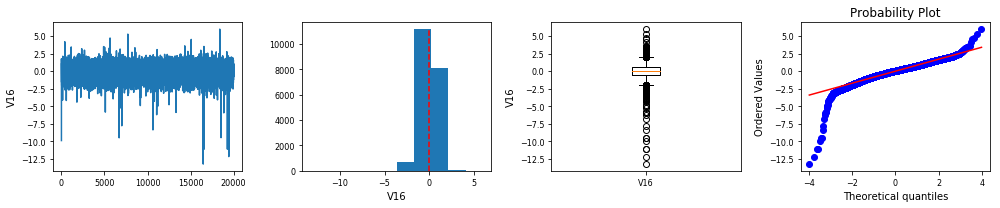

myplots V16


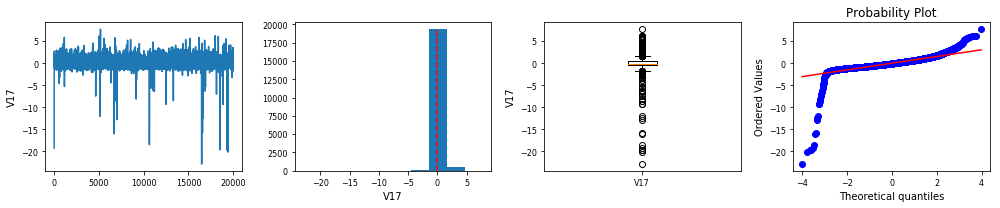

myplots V17


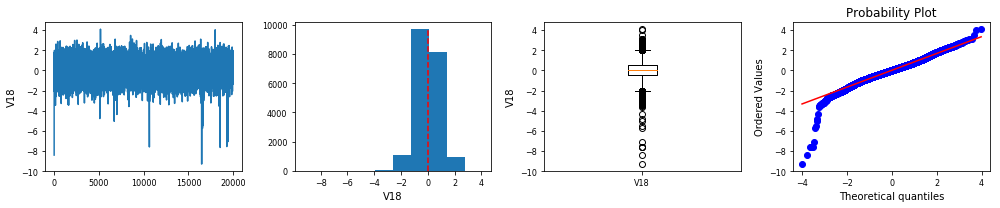

myplots V18


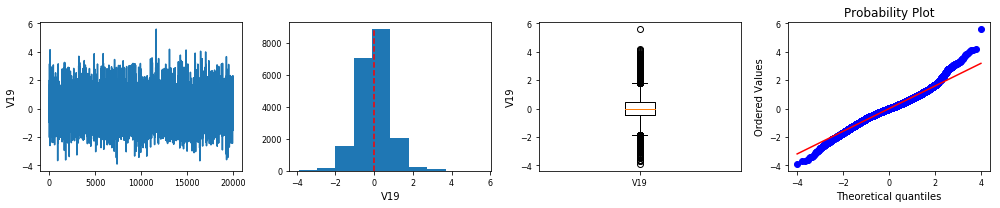

myplots V19


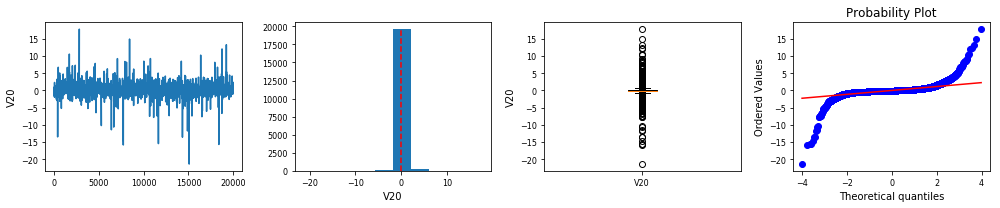

myplots V20


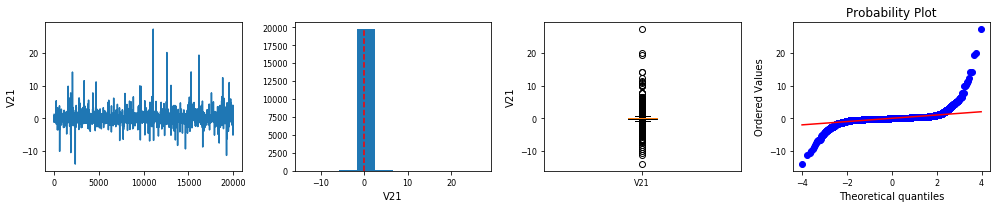

myplots V21


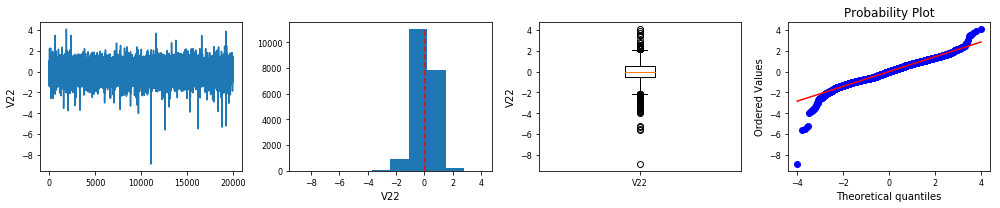

myplots V22


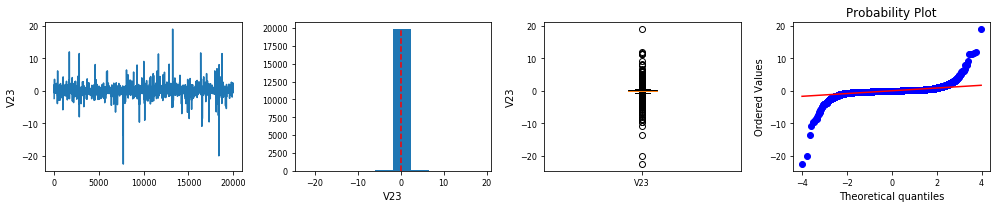

myplots V23


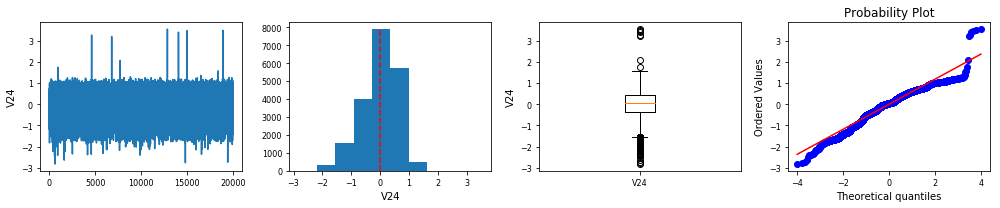

myplots V24


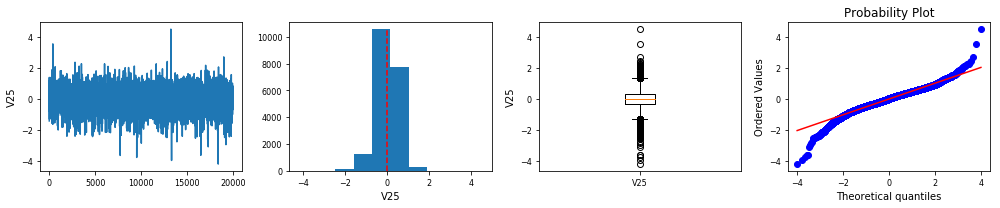

myplots V25


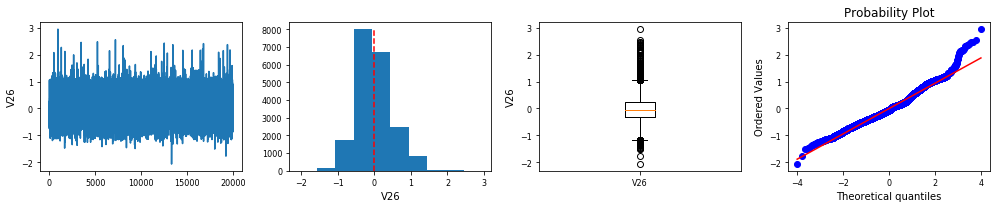

myplots V26


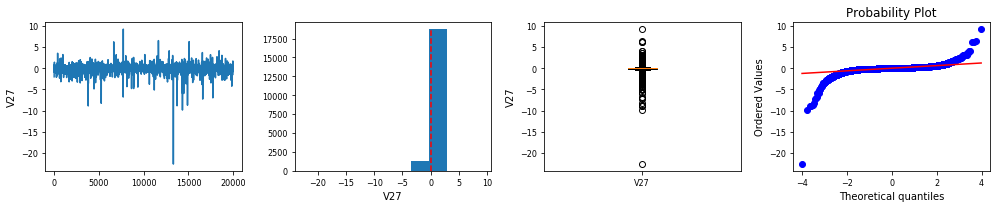

myplots V27


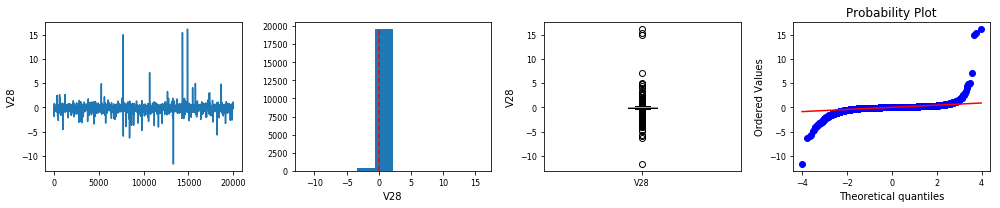

myplots V28


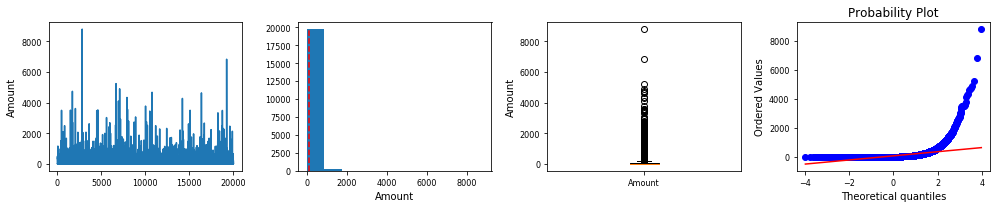

myplots Amount


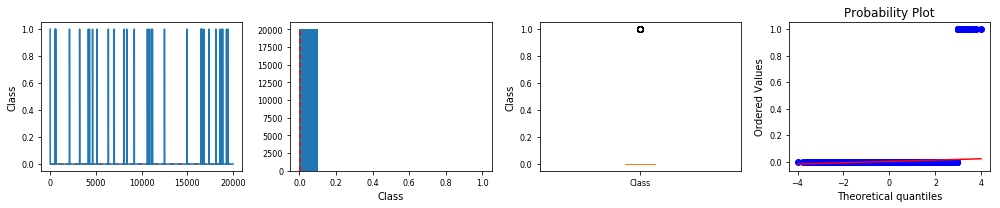

myplots Class


In [0]:
""" 
Displaying the distributions of the data
using visualize.featureplots(crime_stats_dropna.values, crime_stats.columns)
to generate trace plots, histograms, boxplots, and probability plots for
each feature.

A probability plot is utilized to evaulate the normality of a distribution.
The data are plot against a theoritical distribution, such that if the data 
are normal, they'll follow the diagonal line. See the reference above for 
more information.
"""
crime_stats_dropna = crime_stats.dropna()

visualize.featureplots(crime_stats_dropna.values, crime_stats.columns)



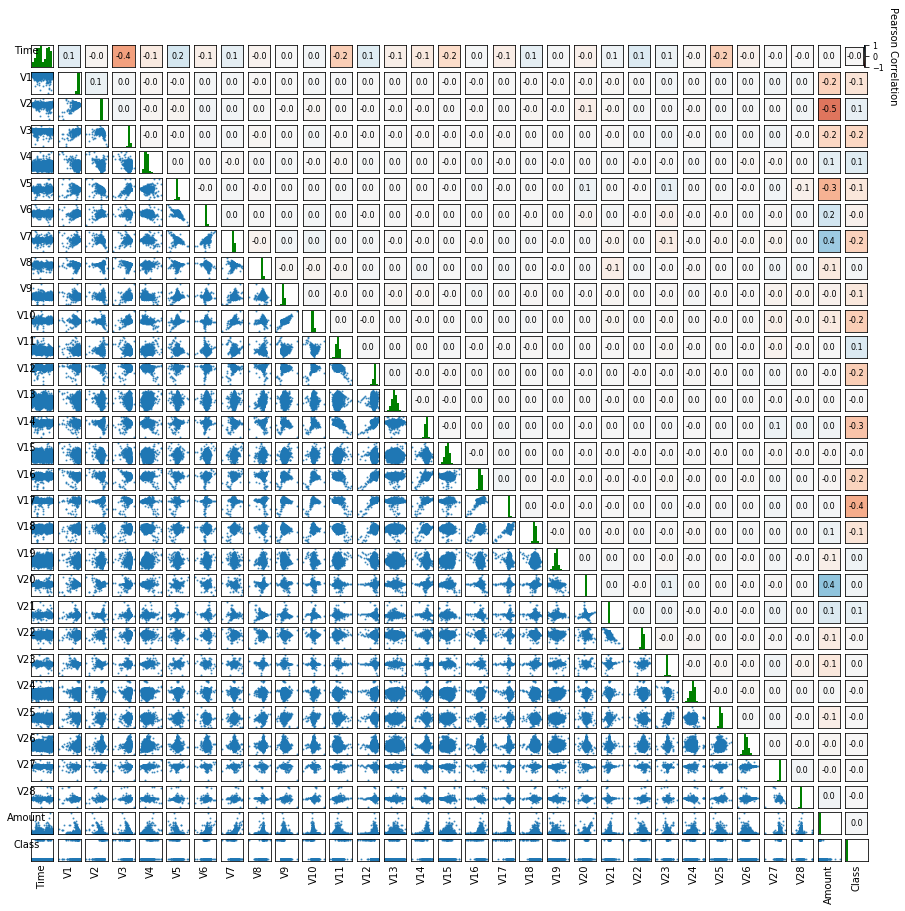

In [0]:
""" 
Displaying the Pearson correlation between all pairs of the features
use visualize.scatter_corrplots(crime_stats_dropna.values, crime_stats.columns, corrfmt="%.1f", FIGW=15)
"""
visualize.scatter_corrplots(crime_stats_dropna.values, crime_stats.columns, corrfmt="%.1f", FIGW=15)

In [0]:
""" 
Separate the postive and negative examples
"""
pos = crime_stats.loc[crime_stats['Class'] == 1] 
neg = crime_stats.loc[crime_stats['Class'] == 0] 

pos.shape, neg.shape

((31, 31), (19969, 31))

In [0]:
""" 
Compute the postive fraction
"""
pos_fraction = pos.shape[0] / nRows
neg_fraction = 1 - pos_fraction

pos_fraction, neg_fraction

(0.00010884602150235599, 0.9998911539784976)

''

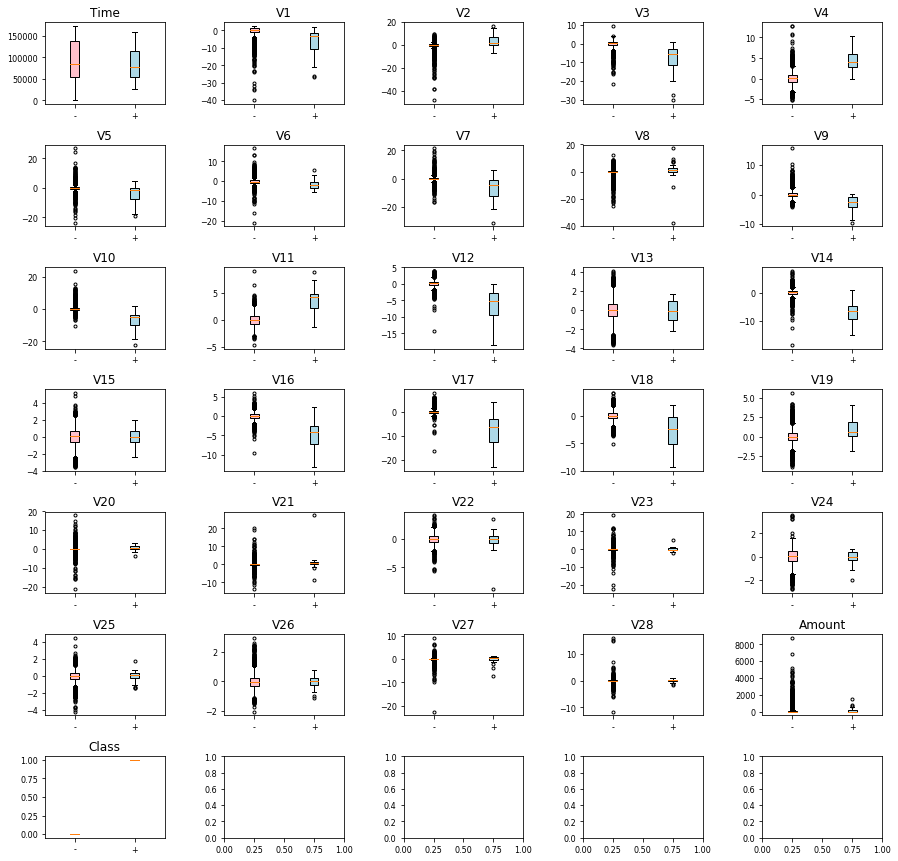

In [0]:
""" 
Compare the features for the positive and negative examples
"""
features_displayed = pos.columns
ndisplayed = len(features_displayed)
ncols = 5
nrows = ceil(ndisplayed / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
fig.subplots_adjust(wspace=.5, hspace=.5)
axs = axs.ravel()
for ax, feat_name in zip(axs, features_displayed):
    boxplot = ax.boxplot([neg[feat_name], pos[feat_name]], patch_artist=True, sym='.')
    boxplot['boxes'][0].set_facecolor('pink')
    boxplot['boxes'][1].set_facecolor('lightblue')
    ax.set_xticklabels(['-', '+'])
    ax.set(title=feat_name)
""""""

# PRE-PROCESS DATA

## Data Clean Up and Feature Selection

In [0]:
""" 
Construct Pipeline to pre-process data
"""
feature_names = crime_stats.columns.drop(['Class'])
pipe_X = Pipeline([
    ("NaNrowDropper", DataSampleDropper()),
    ("selectAttribs", DataFrameSelector(feature_names)),
    ("scaler", RobustScaler())
])

pipe_y = Pipeline([
    ("NaNrowDropper", DataSampleDropper()),
    ("selectAttribs", DataFrameSelector(['Class']))
])

In [0]:
""" 
Pre-process the data using the pipelines
"""
X = pipe_X.fit_transform(crime_stats)

Y = pipe_y.fit_transform(crime_stats)

np.any(np.isnan(X))

False

In [0]:
Y.shape

(20000, 1)

In [0]:
pd.DataFrame(Y).head()

,Class
43428,1
49906,0
29474,0
276480,0
278845,0


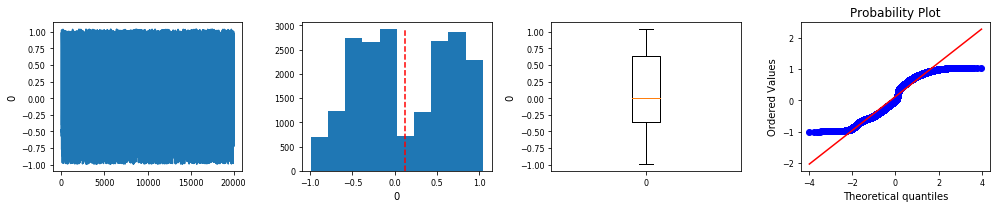

myplots 0


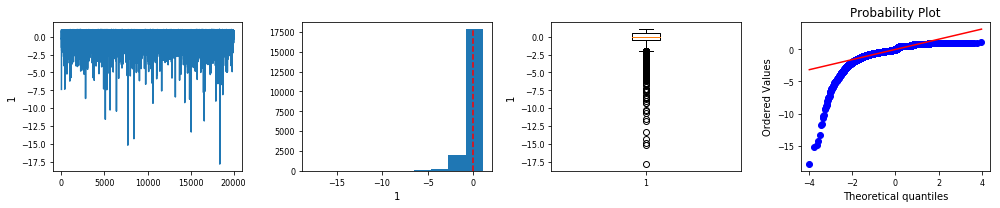

myplots 1


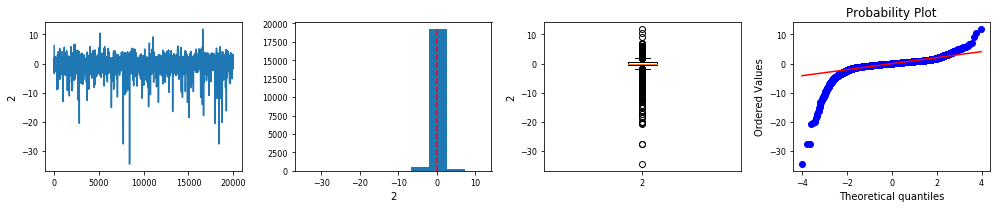

myplots 2


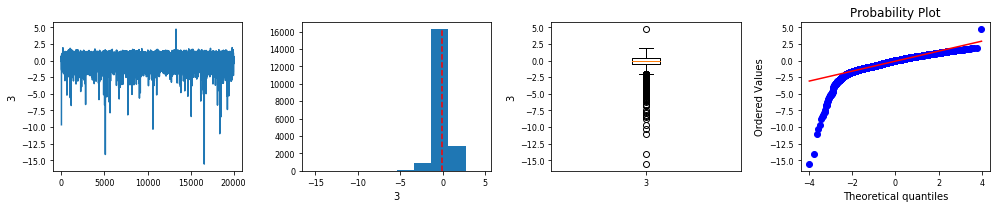

myplots 3


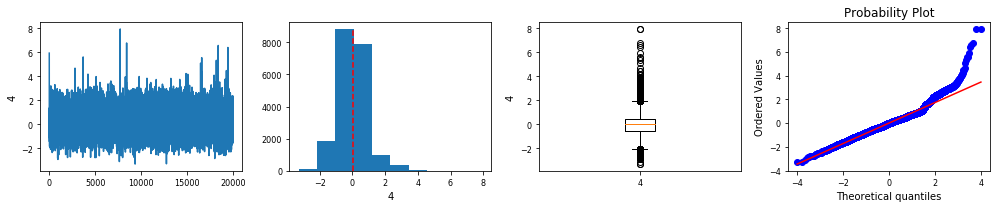

myplots 4


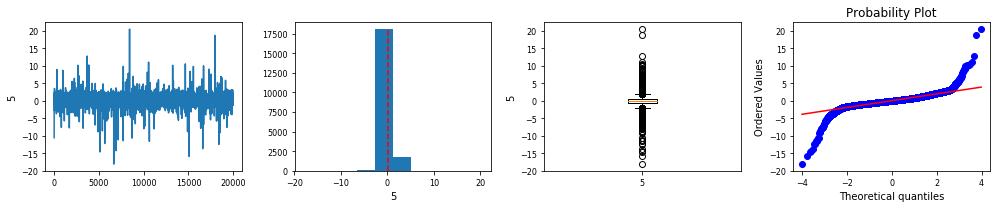

myplots 5


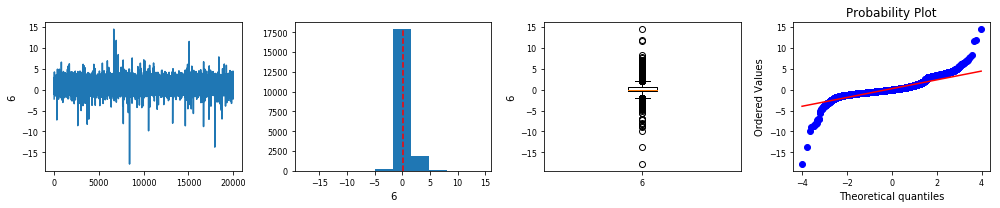

myplots 6


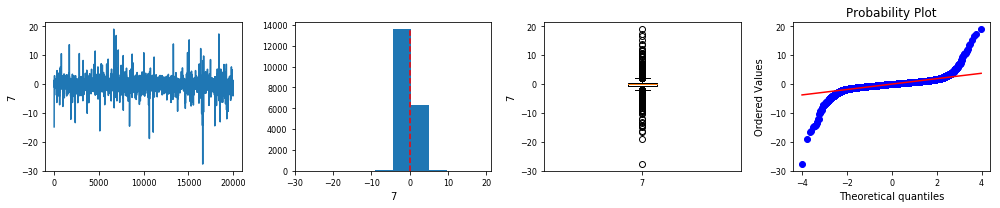

myplots 7


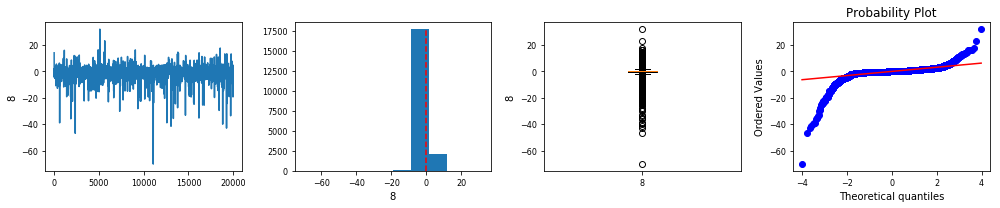

myplots 8


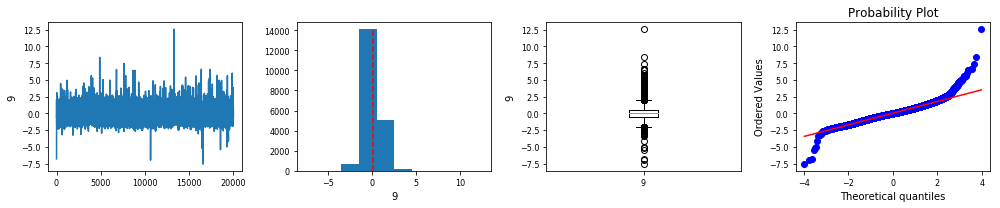

myplots 9


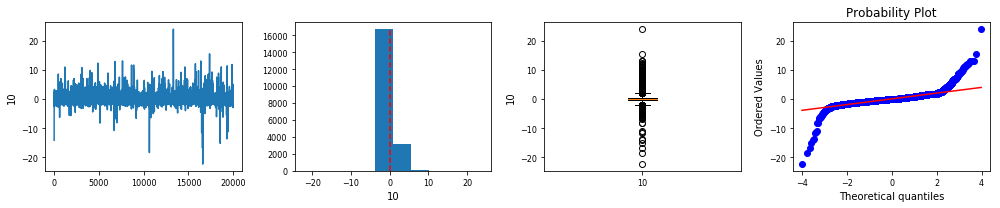

myplots 10


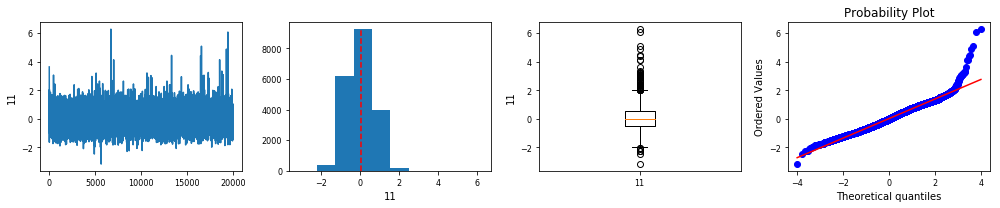

myplots 11


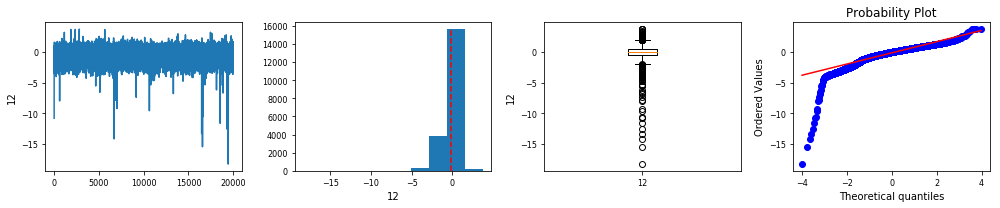

myplots 12


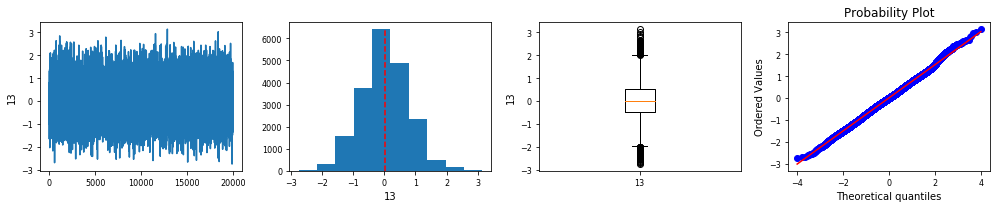

myplots 13


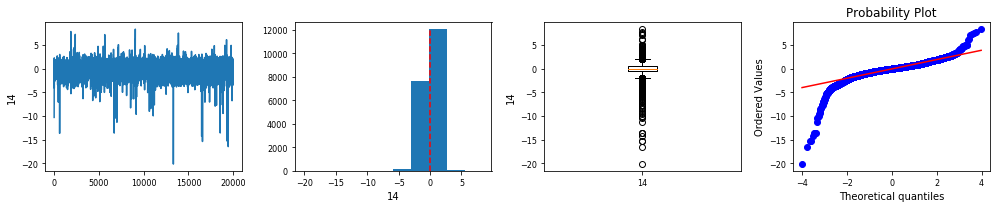

myplots 14


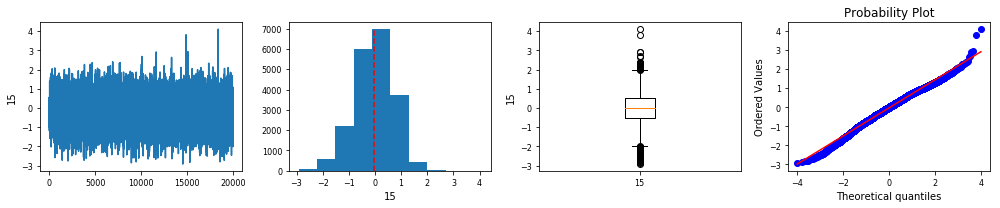

myplots 15


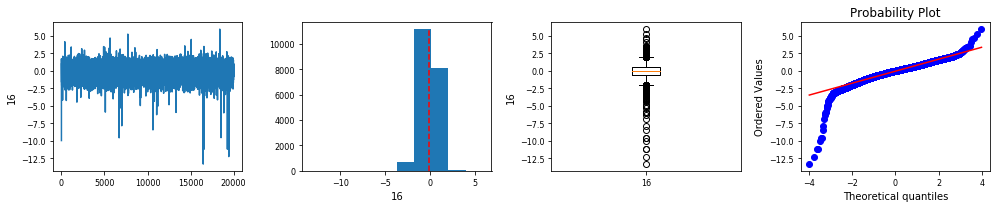

myplots 16


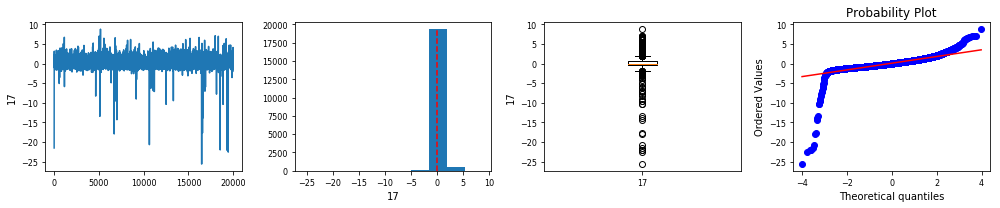

myplots 17


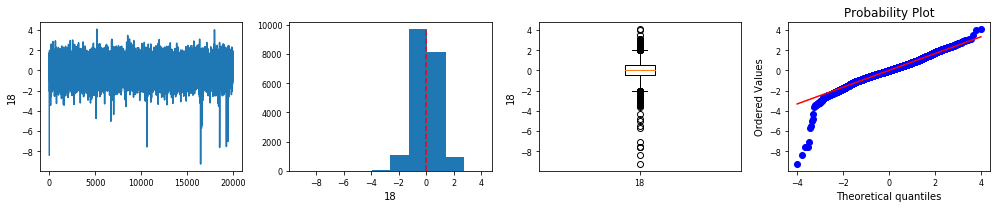

myplots 18


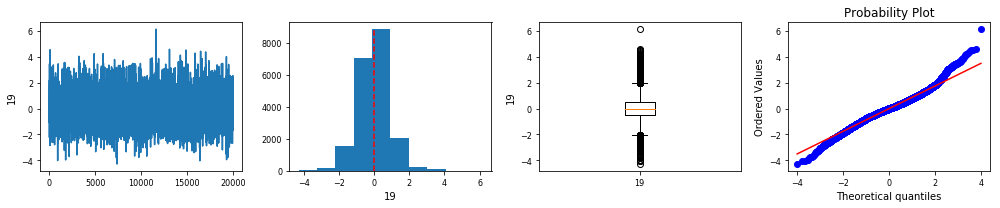

myplots 19


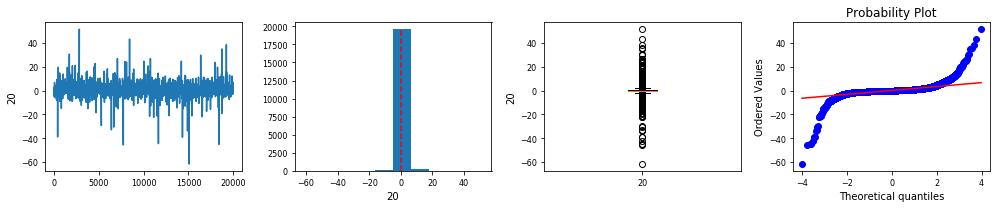

myplots 20


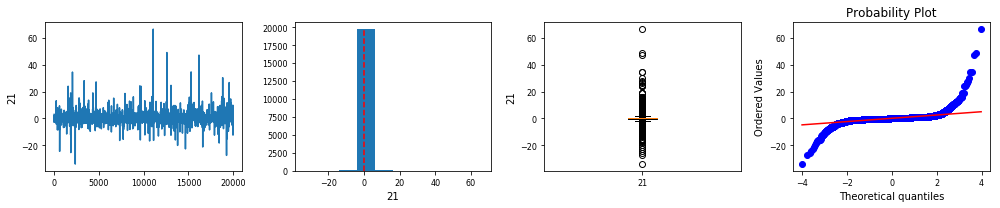

myplots 21


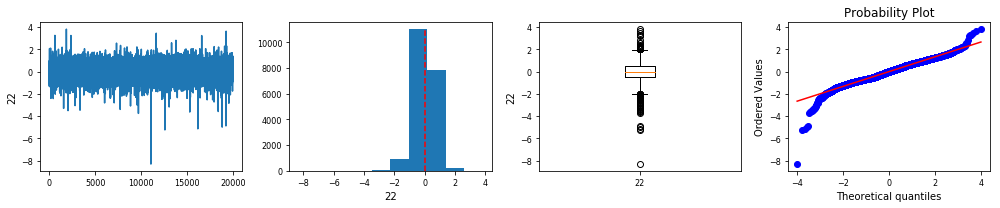

myplots 22


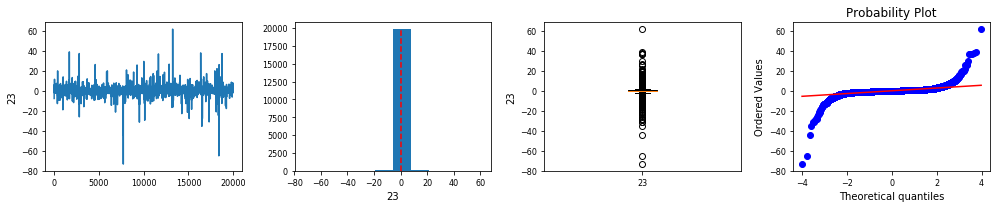

myplots 23


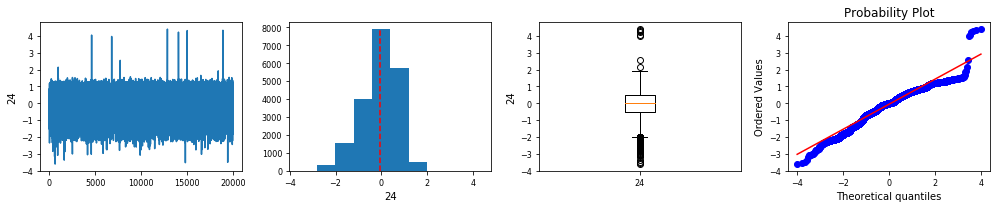

myplots 24


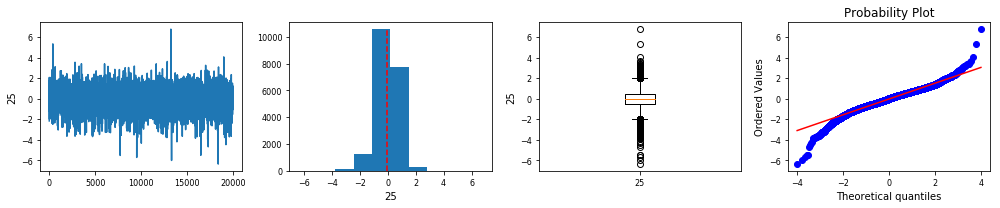

myplots 25


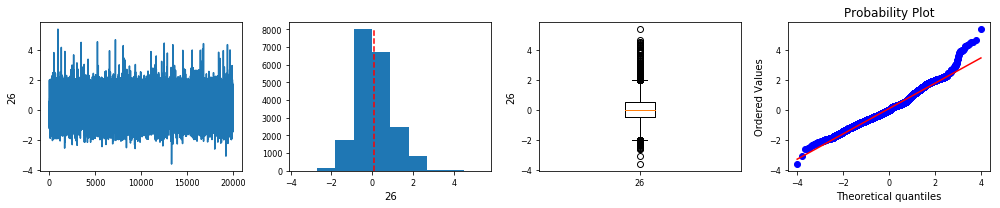

myplots 26


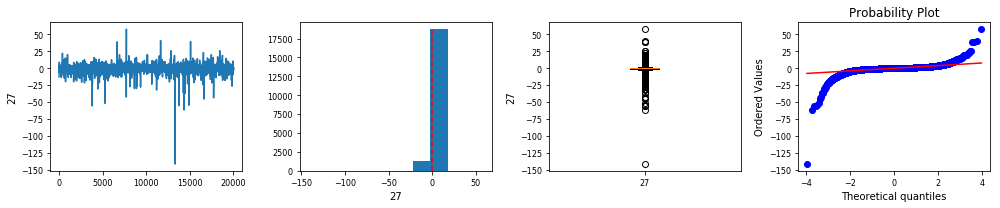

myplots 27


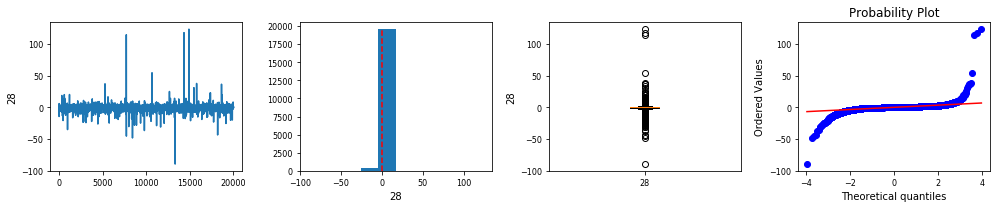

myplots 28


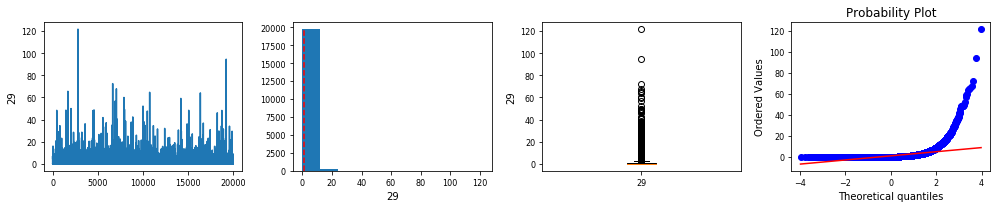

myplots 29


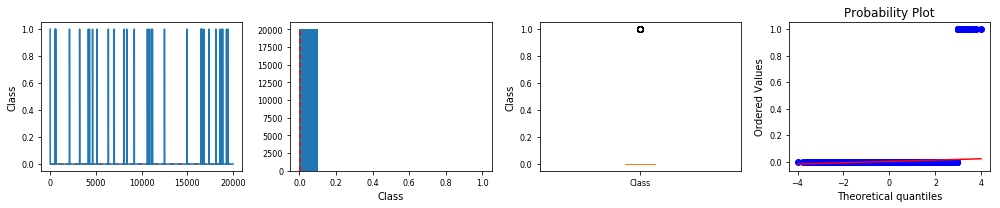

myplots Class


In [0]:
""" 
Re-visualize the pre-processed data
use visualize.featureplots()
"""
X = pd.DataFrame(X)

visualize.featureplots(X.values,X.columns)

visualize.featureplots(Y.values,Y.columns)



# SVMs: EXPLORATION

In [0]:
""" 
Hold out a subset of the data, before training and cross validation
using train_test_split, with stratify NOT equal to None, and a test_size 
fraction of .2.

For this exploratory section, the held out set of data is a validation set.
For the GridSearch section, the held out set of data is a test set.
"""

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, stratify = Y)

x_train.shape,x_test.shape,y_train.shape,y_test.shape


((16000, 30), (4000, 30), (16000, 1), (4000, 1))

In [0]:
FIGURESIZE=(10,6)
FONTSIZE=18

In [0]:
""" 
Create and train SVC models.
Explore various configurations of the hyper-parameters. 
Train the models on the training set and evaluate them for the training and
validation sets.

Play around with C, gamma, and class_weight. Feel free to play with other hyper-
parameters as well. See the API for more details.
C is a regularization parameter, gamma is the inverse of the radius of influence
of the support vectors (i.e. lower gamma means a higher radius of influence of the 
support vectors), and class weight determines whether to adjust the weights inversely
to the class fractions.


"""

#Guassian Kernal
# Fitting Kernel SVC to the Training set

classifier = SVC(kernel='rbf', C=1,gamma='auto',class_weight = 'balanced',probability=True,tol = 0.001)
#classifier = SVC(kernel='rbf', C=10,gamma='auto',class_weight = {0:1, 1:9186},probability=True)
#classifier = SVC(kernel='rbf', C=100,gamma='auto',class_weight = {0:1, 1:9186},probability=True)
#classifier = SVC(kernel='rbf', C=1000,gamma='auto',probability=True)
#classifier = SVC(kernel='rbf', C=10,gamma='auto',probability=True)


#Training the SVC model

classifier.fit(x_train,y_train['Class'])

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

ROC AUC: 1.0
PRC AUC: 1.0
PSS: 0.9999
F1 Score 0.9615


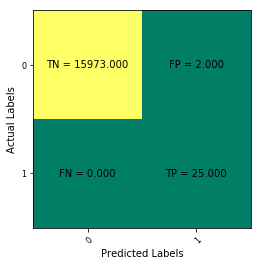

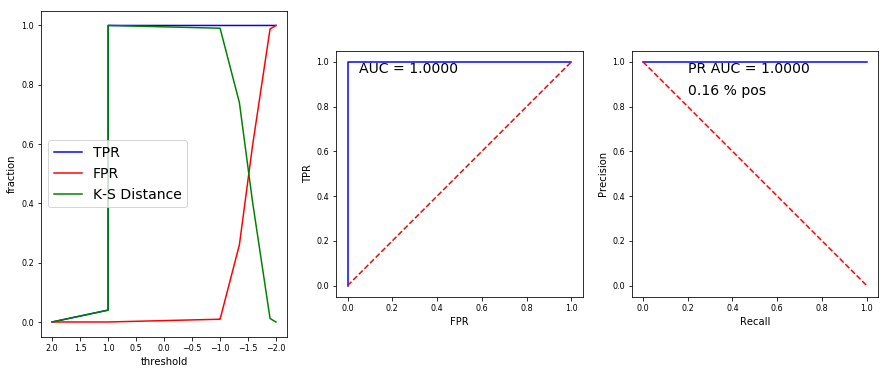

In [0]:
""" 
Evaluate training set performance. 
Display the confusion matrix, KS plot with
the cumulative distributions of the TPR and FPR, the ROC curve and the 
precision-recall curve (PRC). use metrics_plots.ks_roc_prc_plot(ytrue, scores)

The PRC, unlike the AUC, does not consider the true negative (i.e. TN) counts,
making the PRC more robust to unbalanced datasets.
"""
# Confusion matrix
# First, compute the predictions for the training set
label_names = ['0','1']

y_pred_train = classifier.predict(x_train)

# Second, use confusion_matrix

cm_train = confusion_matrix(y_train, y_pred_train)

# Third, use metrics_plots.confusion_mtx_colormap() to display the matrix

metrics_plots.confusion_mtx_colormap(cm_train,label_names,label_names)

#  Curves
# First, use the model's decision function to compute the scores

scores_train = classifier.decision_function(x_train)

# Second, use metrics_plots.ks_roc_prc_plot() to display the KS plot, ROC, and PRC

fig = metrics_plots.ks_roc_prc_plot(y_train,scores_train)

pss_train = metrics_plots.skillScore(y_train.values, y_pred_train)
f1_train = f1_score(y_train.values.ravel(), y_pred_train)
print("PSS: %.4f" % pss_train[0])
print("F1 Score %.4f" % f1_train)

ROC AUC: 0.9865214488399265
PRC AUC: 0.21986876345986517
PSS: -0.0003
F1 Score 0.0000


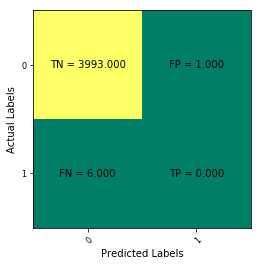

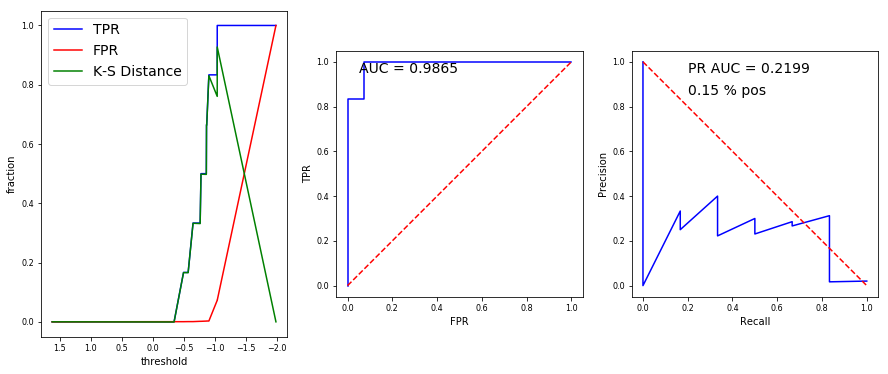

In [0]:
""" 
Evaluate validation performance. 
Display the confusion matrix, KS plot with the cumulative distributions of the TPR 
and FPR, the ROC curve and the precision-recall curve (PRC).
"""
# Confusion matrix

label_names = ['0','1']
y_pred_test = classifier.predict(x_test)

cm_test = confusion_matrix(y_test, y_pred_test)

fig = metrics_plots.confusion_mtx_colormap(cm_test,label_names,label_names)

# Curves

scores_test = classifier.decision_function(x_test)

# Second, use metrics_plots.ks_roc_prc_plot() to display the KS plot, ROC, and PRC

fig = metrics_plots.ks_roc_prc_plot(y_test,scores_test)

pss_test = metrics_plots.skillScore(y_test.values, y_pred_test)
f1_test = f1_score(y_test.values.ravel(), y_pred_test)
print("PSS: %.4f" % pss_test[0])
print("F1 Score %.4f" % f1_test)

# SVMs: STRATIFIED GRID SEARCH

## Scorers

In [0]:
""" 
List of available scoring functions from the sklearn module
"""
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [0]:
""" 
Construct custom scoring functions for the grid search
tn = C[0, 0]
fp = C[0, 1]
fn = C[1, 0]
tp = C[1, 1]
"""
def get_tp(y_true, y_pred):
    '''
    Get number of true positives (i.e. correctly classified positive cases)
    '''
    cmtx = confusion_matrix(y_true, y_pred)
    return cmtx[1,1]

def get_fp(y_true, y_pred):
    '''
    Get number of false positives (i.e. in-correctly classified negative cases)
    '''
    cmtx = confusion_matrix(y_true, y_pred)
    return cmtx[0,1]

def get_tn(y_true, y_pred):
    '''
    Get number of true negatives (i.e. correctly classified negative cases)
    '''
    cmtx = confusion_matrix(y_true, y_pred)
    return cmtx[0,0]

def get_fn(y_true, y_pred):
    '''
    Get number of false negatives (i.e. in-correctly classified positive cases)
    '''
    cmtx = confusion_matrix(y_true, y_pred)
    return cmtx[1,0]

def get_pss(y_true, y_pred):
    '''
    Compute the PSS (Pierce Skill Score)
    '''
    pss_tpr_fpr = metrics_plots.skillScore(y_true, y_pred, skill='pss')
    return pss_tpr_fpr[0]

# TODO: use make_scorer to make get_tn and get_fn scoring functions for grid search
scoring = {'tp': make_scorer(get_tp), 'fp': make_scorer(get_fp), 
           'tn': make_scorer(get_tn) , 'fn':make_scorer(get_fn)  , 
           'AUC': 'roc_auc', 'precision': 'precision', 
           'recall': 'recall', 'f1':'f1'}

## Execute Grid Search

In [0]:
""" 
Set up and run the grid search using GridSearchCV and the following 
settings:
* SVC for the model,
* The above scoring dictionary for scoring,
* refit set to 'f1' as the optimized metric
* Three for the number of cv folds, 
* n_jobs=3, 
* verbose=2, 
* return_train_score=True
"""
# Optimized metric
opt_metric = 'f1'
# Flag to re-load previous run
force = False
# File previous run is saved to
srchfname = "hw8_search_" + opt_metric + ".pkl"

# SETUP EXPERIMENT HYPERPARAMETERS
Cs = [.5, 1, 10, 100, 200]
gammas = np.logspace(-4, 0, num=5, endpoint=True, base=5)

nCs = len(Cs)
ngammas = len(gammas)

hyperparams = {'C':Cs, 'gamma':gammas, 'tol':[1e-4],
               'class_weight':[None, 'balanced']}

# RUN EXPERIMENT
time0 = timelib.time()
search = None
if force or (not os.path.exists(srchfname)):
    # TODO: Create the GridSearchCV object
    search = GridSearchCV(classifier,hyperparams,n_jobs = 3,cv = 3,scoring= scoring ,refit = 'f1',verbose = 2,return_train_score=True) # TODO

    
    # TODO: Execute the grid search by calling fit using the training data
    
    search.fit(x_train,y_train['Class'])

    
    # TODO: Save the grid search object using joblib.dump() or equivalent
    joblib.dump(search, srchfname)

    
    print("Saved %s" % srchfname)
else:
    search = joblib.load(srchfname)
    print("Loaded %s" % srchfname)

time1 = timelib.time()
duration = time1 - time0
print("Elapsed Time: %.2f min" % (duration / 60))

search

Loaded hw8_search_f1.pkl
Elapsed Time: 0.00 min


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'C': [0.5, 1, 10, 100, 200], 'gamma': array([0.0016, 0.008 , 0.04  , 0.2   , 1.    ]), 'tol': [0.0001], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'tp': make_scorer(get_tp), 'fp': make_scorer(get_fp), 'tn': make_scorer(get_tn), 'fn': make_scorer(get_fn), 'AUC': 'roc_auc', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'},
       verbose=2)

# RESULTS

In [0]:
""" 
Display the head of the results for the grid search
See the cv_results_ attribute
"""
all_results = search.cv_results_
df_res = pd.DataFrame(all_results)
df_res.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_tol,params,split0_test_tp,...,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,mean_train_f1,std_train_f1
0,0.587714,0.059262,0.297046,0.039463,0.5,None,0.0016,0.0001,"{'C': 0.5, 'class_weight': None, 'gamma': 0.00...",5.0,...,0.222222,0.615385,0.487544,0.187643,16,0.740741,0.592593,0.689655,0.674330,0.061444
1,1.402927,0.093991,0.701288,0.075559,0.5,None,0.008,0.0001,"{'C': 0.5, 'class_weight': None, 'gamma': 0.00...",2.0,...,0.000000,0.400000,0.235902,0.171004,20,0.545455,0.521739,0.300000,0.455731,0.110543
2,4.047113,0.140496,2.026613,0.038199,0.5,None,0.04,0.0001,"{'C': 0.5, 'class_weight': None, 'gamma': 0.04...",0.0,...,0.000000,0.000000,0.000000,0.000000,21,0.000000,0.000000,0.000000,0.000000,0.000000
3,25.024405,1.233387,10.403316,0.360121,0.5,None,0.2,0.0001,"{'C': 0.5, 'class_weight': None, 'gamma': 0.2,...",0.0,...,0.000000,0.000000,0.000000,0.000000,21,0.000000,0.000000,0.000000,0.000000,0.000000
4,63.576461,0.835280,23.801883,0.998634,0.5,None,1,0.0001,"{'C': 0.5, 'class_weight': None, 'gamma': 1.0,...",0.0,...,0.000000,0.000000,0.000000,0.000000,21,0.000000,0.000000,0.000000,0.000000,0.000000


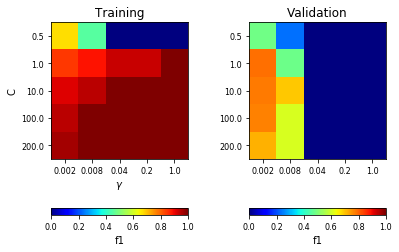

In [0]:
""" 
Plot the mean training and validation results from the grid search as a
colormap, for C (y-axis) vs the gamma (x-axis), for class_weight=None
"""
results_grid_train = df_res['mean_train_'+opt_metric].values.reshape(nCs, 2, ngammas)
results_grid_val = df_res['mean_test_'+opt_metric].values.reshape(nCs, 2, ngammas)

fig, axs = plt.subplots(1, 2, figsize=(6,6))
fig.subplots_adjust(wspace=.45)
axs = axs.ravel()
means = [("Training", results_grid_train),
         ("Validation", results_grid_val)]
for i, (name, result) in enumerate(means):
    img = axs[i].imshow(result[:,0,:], cmap="jet", vmin=0, vmax=1)
    axs[i].set_title(name)
    axs[i].set_xticks(range(ngammas))
    axs[i].set_yticks(range(nCs))
    axs[i].set_xticklabels(np.around(gammas, 3))
    axs[i].set_yticklabels(np.around(Cs, 3))
    axs[i].figure.colorbar(img, ax=axs[i], label=opt_metric, 
                           orientation='horizontal')
    if i == 0:
        axs[i].set_xlabel(r"$\gamma$")
        axs[i].set_ylabel("C")
#fig.suptitle('class_weight=None')

In [0]:
""" 
Obtain the best model from the grid search and 
fit it to the training data
"""

print(search.best_params_)
print(search.best_score_)

classifier1 = search.best_estimator_
classifier1.fit(x_train,y_train['Class'])

{'C': 1, 'class_weight': None, 'gamma': 0.0016, 'tol': 0.0001}
0.7925916666666667


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0016, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.0001, verbose=False)

ROC AUC: 0.9970754303599374
PRC AUC: 0.7914241776946348
PSS: 0.7998
F1 Score 0.8333


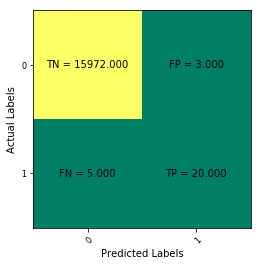

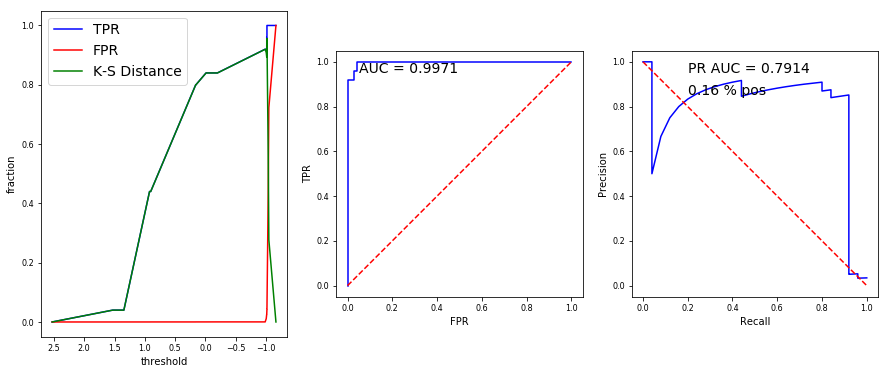

In [0]:
""" 
For the best model, display the confusion matrix, KS plot, ROC curve, 
and PR curve for the training set
"""
#  Confusion Matrix

pred_search_train = classifier1.predict(x_train)

cm_search = confusion_matrix(y_train, pred_search_train)

fig = metrics_plots.confusion_mtx_colormap(cm_search,label_names,label_names)

#  Curves

scores_train_search = classifier1.decision_function(x_train)

# Second, use metrics_plots.ks_roc_prc_plot() to display the KS plot, ROC, and PRC

fig = metrics_plots.ks_roc_prc_plot(y_train,scores_train_search)



pss_res = get_pss(y_train.values.ravel(), pred_search_train)
f1_res = f1_score(y_train.values.ravel(), pred_search_train)
print("PSS: %.4f" % pss_res)
print("F1 Score %.4f" % f1_res)

ROC AUC: 0.9440827908529461
PRC AUC: 0.5229060235734082
PSS: 0.6664
F1 Score 0.7273


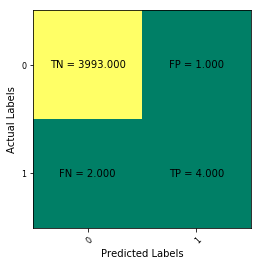

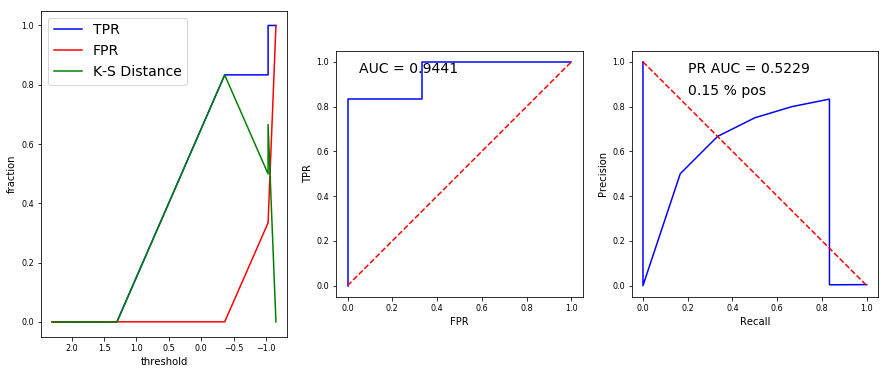

In [0]:
""" 
For the best model, display the confusion matrix, KS plot, ROC curve, 
and PR curve for the test set
"""
#  Confusion Matrix

pred_search_test = classifier1.predict(x_test)

cm_search_test = confusion_matrix(y_test, pred_search_test)

fig = metrics_plots.confusion_mtx_colormap(cm_search_test,label_names,label_names)

#  Curves

scores_test_search = classifier1.decision_function(x_test)

# Second, use metrics_plots.ks_roc_prc_plot() to display the KS plot, ROC, and PRC

fig = metrics_plots.ks_roc_prc_plot(y_test,scores_test_search)



pss_res_test = get_pss(y_test.values.ravel(), pred_search_test)
f1_res_test = f1_score(y_test.values.ravel(), pred_search_test)
print("PSS: %.4f" % pss_res_test)
print("F1 Score %.4f" % f1_res_test)

[Text(0.5, 1.0, 'Positive Examples Vs Negative Examples')]

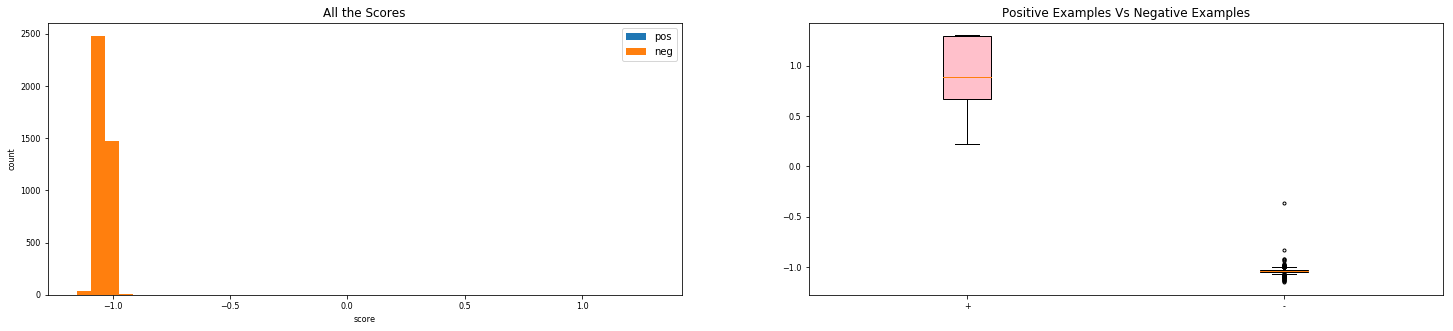

In [0]:
""" 
Plot a histogram of the test scores from the best model.
Compare the distribution of scores for positive and negative examples
using boxplots.

Create one subplot of the distribution of all the scores, with a histogram. 
Create a second subplot comparing the distribution of the scores of the 
positive examples with the distribution of the negative examples, with boxplots.
"""
#  Obtain the pos and neg indices

#pos_index = np.where(pred_search_test==1) 
#neg_index = np.where(pred_search_test==0)

pos_inds = np.where(y_test)[0]
neg_inds = np.where(y_test == 0)[0]

# Separate the scores for the pos and neg examples

#pred_search_test_pos = scores_test_search[pos_index] 
#pred_search_test_neg = scores_test_search[neg_index]


proba_pos = scores_test_search[pos_inds]
proba_neg = scores_test_search[neg_inds]

# Plot the distribution of all scores
nbins = 41
plt.figure(figsize=(25, 5)) 
plt.subplot(1,2,1) 
plt.hist(proba_pos,nbins)
plt.hist(proba_neg,nbins)
plt.title("All the Scores")
plt.xlabel('score', fontsize=FONTSIZE)
plt.ylabel('count', fontsize=FONTSIZE)
plt.legend(['pos', 'neg'])


#  Plot the boxplots of the pos and neg examples

ax = plt.subplot(1,2,2) 
boxplot = plt.boxplot([pred_search_test_pos,pred_search_test_neg],patch_artist=True, sym='.')
boxplot['boxes'][0].set_facecolor('pink') 
boxplot['boxes'][1].set_facecolor('lightblue') 
ax.set_xticklabels(['+', '-'])
ax.set(title="Positive Examples Vs Negative Examples")



In [0]:
scores_test_search

array([-1.05428438, -1.02065364, -1.06470157, ..., -1.01763723,
       -1.02590812, -1.04444874])

# Discussion



From the above test results for our best model, I get a F1 score of 0.7273. As F1 score summarizes both precision and recall we can see that our model can perform better as the value is not close to 1, If we would have got a F1 score of 1 we can conclude our model was predicting all the values correct.

But, In our case since we have very less positive values it was difficult to balance the data.That must be reason for having a low F1 score

# Difference in the meaning of the AUC for the ROC vs the AUC for the PRC.

Since, we are dealing with class imbalance problem, using acccuracy or any other metric might not give us resonable results.

so we consider ROC AUC(Receiver Operating Characteristic area under curve) and PRC AUC(Precision Recall area under curve)

A ROC curve is plotting True Positive Rate against False Positive Rate, we would like to have a model to be at the upper left corner which in other words is to have a model which will not give us any false positives.

ROC AUC is the area under the ROC curve. The higher it is, the better the model.For our best model we have 0.944
for ROC AUC, which is pretty good

A PR curve is plotting Precision against Recall, we would like to have a model be at the upper right corner, which is basically getting only the true positives with no false positives and no false negatives

The PRC AUC is just the area under the PRC curve. The higher it is, the better the model.For our best model we have 0.522 for ROC AUC, which is not really good.

### Since our problem has a more negatives than positives and PRC does not consider true negatives it would be better to use PRC as our metric. Using ROC as a metric we might end up thinking our model is performing really well, but reality is it considers True Negatives and if our data has lots of negative examples we will end up getting better results for ROC AUC, which I believe the case above.



I have a really good ROC AUC value, but my PRC AUC is not close to good.
I can say that my model is not performing well on this data, we might want to check other classifiers to check their performance.


# Histogram and boxplots of the scores

The Hitogram was plotted for all the predicted scores of our model. we can see that most of the prediction scores fall in the negative side of the plot and range is somewhere betwwn -1.5 to -0.5. This is evident from the fact that model has only around 7 positive values to detect be detected, that must the reason the model has more chances of identifying negative cases correctly.If closly examined we can see the spread for postive values too.


Coming to the boxplot, we try to see the scores of both positive and negative examples.The Negative class scores fall in the negatives and we can see some outliers, and positive values are values greater than 0.1 and has some values greater than 1. From these plots we can get fair idea of distribution of our test scores.